In [153]:
from __future__ import absolute_import, division, print_function, unicode_literals
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

In [154]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [155]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pathlib

In [156]:
tf.__version__

'2.4.0'

In [157]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [158]:
# split to valid and training

In [159]:
data_dir="/content/drive/My Drive/Infa/IWiUM/transformed_train_zoom500_dim130x100/data_train/"
test_dir="/content/drive/My Drive/Infa/IWiUM/transformed_test_zoom500_dim130x100/data_test/"
data_dir = pathlib.Path(data_dir)
test_dir = pathlib.Path(test_dir)

In [160]:
image_count = len(list(data_dir.glob('*/*.png')))
image_count

2010

In [161]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['LowRm', 'HighRm'], dtype='<U6')

In [162]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [163]:
BATCH_SIZE = 32
IMG_HEIGHT = 130
IMG_WIDTH = 100
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [164]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30,
validation_split=0.2
)

train_data_gen = train_datagen .flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                    #  shuffle=True,
                                                     target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                     classes = list(CLASS_NAMES))

valid_data_gen = train_datagen .flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                    #  shuffle=True,
                                                     target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                     classes = list(CLASS_NAMES))

Found 2010 images belonging to 2 classes.
Found 2010 images belonging to 2 classes.


In [165]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

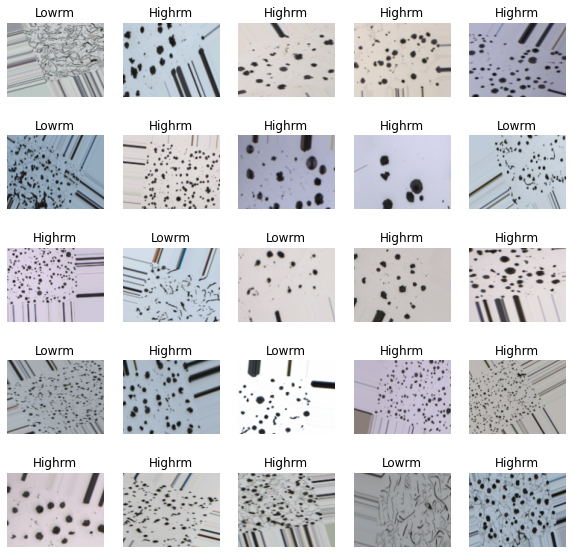

In [166]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

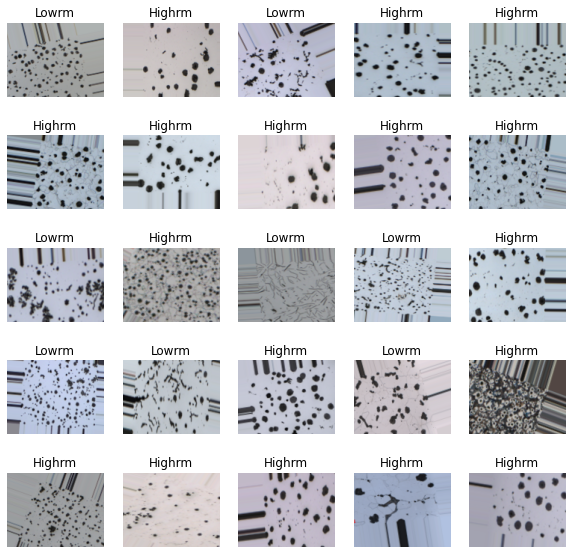

In [167]:
valid_image_batch, valid_label_batch = next(valid_data_gen)
show_batch(valid_image_batch, valid_label_batch)

In [168]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [169]:
keras = tf.keras

In [170]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
IMG_SHAPE

(100, 130, 3)

In [171]:
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [172]:
#base_model.trainable = False
for layer in base_model.layers[:5]:
    layer.trainable = False

In [173]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100, 130, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 130, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 130, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 65, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 65, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 65, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 32, 128)       0     

In [174]:
image_batch.shape

(32, 100, 130, 3)

In [175]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 4, 512)


In [176]:
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers

In [177]:
layer1 = keras.layers.Dense(1024, activation="relu")
layer1_batch = layer1(feature_batch)
print(layer1_batch.shape)

(32, 3, 4, 1024)


In [178]:
layer2 = keras.layers.Dropout(rate=0.5)
layer2_batch = layer2(layer1_batch)
print(layer2_batch.shape)

(32, 3, 4, 1024)


In [179]:
layer3 = keras.layers.Dense(1024, activation="relu")
layer3_batch = layer3(layer2_batch)
print(layer3_batch.shape)

(32, 3, 4, 1024)


In [180]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(layer3_batch)
print(feature_batch_average.shape)

(32, 1024)


In [181]:
prediction_layer = keras.layers.Dense(2, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [182]:
model = tf.keras.Sequential([
  base_model,
  layer1,
  layer2,
  layer3,
  global_average_layer,
  prediction_layer
])

In [183]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.SGD(lr=base_learning_rate, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 3, 4, 512)         20024384  
_________________________________________________________________
dense_9 (Dense)              (None, 3, 4, 1024)        525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 4, 1024)        0         
_________________________________________________________________
dense_10 (Dense)             (None, 3, 4, 1024)        1049600   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 2050      
Total params: 21,601,346
Trainable params: 21,488,770
Non-trainable params: 112,576
____________________________________

In [184]:
len(model.trainable_variables)

32

In [185]:
initial_epochs = 50
steps_per_epoch = BATCH_SIZE
validation_steps = 20

In [186]:
loss0,accuracy0 = model.evaluate(valid_data_gen, steps = validation_steps)

20/20 [==============================] - 221s 12s/step - loss: 0.6802 - accuracy: 0.6425


In [187]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.68
initial accuracy: 0.65


In [188]:
history = model.fit(train_data_gen,
                    epochs=initial_epochs,
                    validation_data=valid_data_gen)

Epoch 1/50
63/63 [==============================] - 485s 8s/step - loss: 0.6264 - accuracy: 0.6821 - val_loss: 0.6045 - val_accuracy: 0.6786
Epoch 2/50
63/63 [==============================] - 23s 364ms/step - loss: 0.5981 - accuracy: 0.6801 - val_loss: 0.5738 - val_accuracy: 0.6980
Epoch 3/50
63/63 [==============================] - 23s 364ms/step - loss: 0.5591 - accuracy: 0.7035 - val_loss: 0.5213 - val_accuracy: 0.7522
Epoch 4/50
63/63 [==============================] - 23s 360ms/step - loss: 0.4972 - accuracy: 0.7652 - val_loss: 0.4395 - val_accuracy: 0.7990
Epoch 5/50
63/63 [==============================] - 22s 356ms/step - loss: 0.4146 - accuracy: 0.8299 - val_loss: 0.4658 - val_accuracy: 0.7706
Epoch 6/50
63/63 [==============================] - 22s 351ms/step - loss: 0.4069 - accuracy: 0.8264 - val_loss: 0.3583 - val_accuracy: 0.8567
Epoch 7/50
63/63 [==============================] - 22s 349ms/step - loss: 0.3437 - accuracy: 0.8622 - val_loss: 0.3441 - val_accuracy: 0.8667
E

In [191]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [190]:
history

In [192]:
loss = history.history['loss']
val_loss = history.history['val_loss']

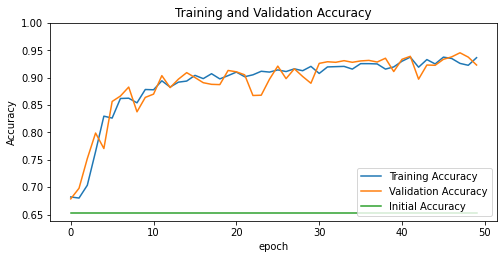

In [193]:
initial = []
for i in range(len(val_acc)):
  initial.append(accuracy0)


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot(initial, label="Initial Accuracy")
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.show()

In [194]:
path_to_save = '/content/drive/My Drive/Infa/IWiUM/models/model1'
model.save_weights(path_to_save)
# model.load_weights(path_to_save)

In [213]:
test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
)

test_data_gen = test_datagen.flow_from_directory(directory=str(test_dir),
                                                     batch_size=400,
                                                     shuffle=False,
                                                     target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                     classes = list(CLASS_NAMES))



test_data = test_data_gen[0]

Found 241 images belonging to 2 classes.


TRUE : PREDICTED


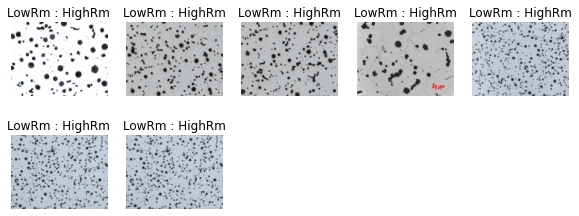

In [228]:
v_predictions = model.predict(test_data[0])
v_predictions_cl = v_predictions.tolist()
v_predictions_cl = list(map(lambda x: (x.index(max(x)), max(x)), v_predictions_cl))
classes = []
for cl in test_data[1]:
  classes.append(np.argmax(cl))
i = 0
plt.figure(figsize=(10,10))
n=0
all = 0
nok = 0
print('TRUE : PREDICTED')
for (cl, val) in v_predictions_cl:
  all += 1
  if cl != classes[i]:
      nok += 1
      # print(str(classes[i]) + ' : ' + str(cl))
      plt.imshow(test_data[0][i])
      ax = plt.subplot(5,5,n+1)
      plt.imshow(test_data[0][i])
      plt.title(CLASS_NAMES[classes[i]] + ' : ' + CLASS_NAMES[cl])
      plt.axis('off')
      n+=1
    # print(cl)
    # print(CLASS_NAMES[cl])
    # plt.imshow(test_data[0][i])
  i += 1

In [230]:
print("Accuracy is: {}".format(float((1-nok/all)*100)))

Accuracy is: 97.0954356846473


In [246]:
for cl in test_data[1]:
  classes.append(np.argmax(cl))
i = 0
plt.figure(figsize=(32,62))
n=0
print('TRUE : PREDICTED')
for (cl, val) in v_predictions_cl:
  plt.imshow(test_data[0][i])
  ax = plt.subplot(32,8,n+1)
  plt.imshow(test_data[0][i])
  plt.title(CLASS_NAMES[classes[i]] + ' : ' + CLASS_NAMES[cl])
  plt.axis('off')
  n+=1
  i += 1

Output hidden; open in https://colab.research.google.com to view.